# Prototipo contador de palabras en un audio

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import soundfile as sf

Los archivos de audios fueron renombrados
con una letra en del abecedario
1. a.ogg
2. b.ogg
3. c.ogg
4. d.ogg
5. e.ogg
6. f.ogg
7. g.ogg
8. h.ogg
9. i.ogg
10. j.ogg
11. k.ogg
12. l.ogg
13. m.ogg
14. n.ogg
15. o.ogg

Los archivos de utilizan el formato __ogg__, puede que sea uno más común en celulares.
ogg guadarla los archivos en la frequencia _48000 Hz_ que es de buena calidad. Las maximas frecuencias que puede escuchar el oido humano son 2000 Hz y para evitar distorcion _aliasing_ se recomienda que la frecuencia sea al menos el doble de la señal _~20kHz_.
Nyquest = Frequency / 2

## Graficar la señal de los audios de pruebas

In [2]:
PATH="/Users/adrian/new-notebook/samples"
def plot_audio(file_name):
    Signal,sample_rate = librosa.load(os.path.join(PATH,file_name), duration=10)
    librosa.display.waveplot(Signal,sr=sample_rate, alpha=0.5)
    plt.xlabel('Time (seconds)')
    plt.ylabel("Amplitude")
    plt.title(f'First 10 secons of audio: {file_name}')
    plt.show()

/Users/adrian/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


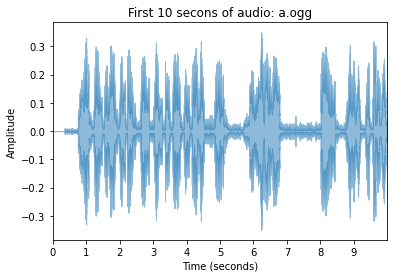

In [3]:
# Nombres de los archivos
file_names = ["a.ogg","b.ogg","c.ogg","d.ogg","e.ogg",
              "f.ogg","g.ogg","h.ogg","i.ogg","j.ogg",
              "k.ogg","l.ogg","m.ogg","n.ogg","o.ogg"]

file_names = ["a.ogg"]
for file_name in file_names:
    plot_audio(file_name)


| Audio | Fragmentos, (considerados palabras) | 
| --- | --- |
| a.wav | 66 |
| b.wav | 57 |
| c.wav |  124|
| d.wav |  84|
| e.wav |  110|
| f.wav |  198|
| g.wav |  130|
| h.wav |  90|
| i.wav |  85|
| j.wav |  59|
| k.wav |  167|
| l.wav |  78|
| m.wav |  235|
| n.wav |  214|
| o.wav |  58|

La tabla de arriba muestra los resultados obtenidos con este experimiento,
en un par las cantidad de palabras contadas fue muy cercano,
pero en otros audios donde varias palabras fueron leidas silaba a silaba se cuentan varias veces,
en algunos de los audios no se leyo todo el parrafo, pero la cantidad de palabas en la lectura _"el cuento más contado"_ son al rededor de 160.


In [4]:
Signal,sr = librosa.load(os.path.join(PATH,'a.ogg'))

/Users/adrian/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


El warning solo indica que utilizara el metodo fallback para leer el archivo que puede ser _ffmpg_
A continuación se muestra el _sample_rate_
**220500* 2 = 44100** otra frecuencia usada muy comunmente

In [5]:
Signal.shape

(1448638,)

Aplicar la funcion **Short-time Fourier transform (STFT)** es una versión de Fourier Transform
stft recibe como parametros:
1. La señal 
2. nftt, que el tamaño de los frames
3. hope_size, el tamaño de el _windowing_ u _overlapping_ entre los frames e internamente correr alguna función de windowing


In [6]:
n_fft = 2048
coeffficients = librosa.stft(Signal,n_fft=n_fft, hop_length=n_fft//2)
print("shape")
print(coeffficients.shape)

shape
(1025, 1415)


In [7]:
# decibel maximo
db = librosa.amplitude_to_db(np.abs(coeffficients),ref=np.max)
np.max(abs(db))

80.0

Utilizo la función split para dividir la señal en fragmentos _(palabras)_ donde su decibel es mayor a _20db_

In [8]:
fragments = librosa.effects.split(Signal, top_db=20) # audio above 20db
print("Cantidad de fragmentos (palabras) detectadas: ", len(fragments))

Cantidad de fragmentos (palabras) detectadas:  66


**Nota:** la separación de palabras va depender de cada audio, pero en algunos audios la separación fue buena, solo en algunos audios donde algunas palabras son leidas silaba a silaba son separadas.

In [9]:
def save_audio_fragments(fragments,Signal, file_name):
    for i in fragments:
        sf.write('samples/words/'+file_name.split(".")[0]+"_"+ str(i) +".wav", Signal[i[0]:i[1]], sr)
        
save_audio_fragments(fragments,Signal,"a.wav")

Esta opción puede funcionar si logra limpiar la señal, acontinuación mostrare algunos de los metodos a utilizar.
Estoy experimentado con ellos , lei que son utilizados en _speech_recognition_ y algunos filtro que pienso, pueden ser utilizados para limpiar la señal como: two stage-wide band, (lower,high) bands
- **Zero-crossing rate**
- **Root-mean-square energy**
- **Mel-frequency ceptrum coefficients (MFCC)**

**Zero-crossing rate**
puede ser utilizado para eliminar ruido, indica los cambios de la señal (las veces que la señal cambia de positivo a negativo).

En la grafica siguiente, la linea amarilla puede indicar alto nivel de ruido


In [10]:
FRAME_SIZE = 1024
HOP_LENGTH = 512
zcr = librosa.feature.zero_crossing_rate(Signal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [11]:
frames = range(len(zcr))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

Text(0.5, 1.0, 'El cuento más contado')

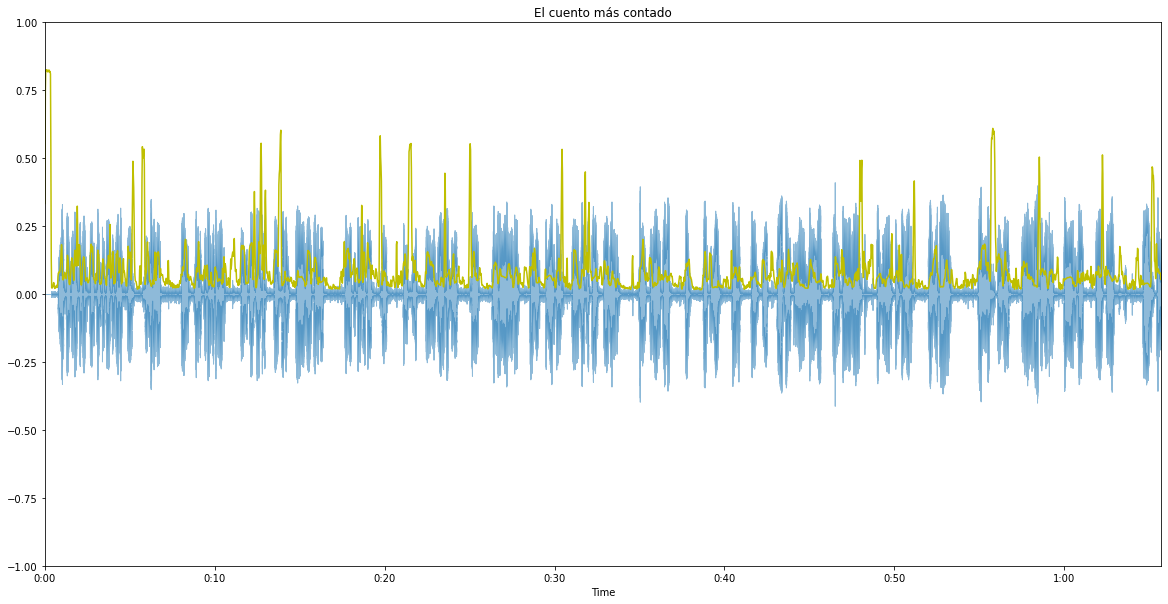

In [12]:
plt.figure(figsize=(20, 10))

librosa.display.waveplot(Signal, alpha=0.5)
plt.plot(t, zcr, color="y")
plt.ylim((-1, 1))
plt.title("El cuento más contado")

**Root-mean-squared energy**
Obtiene el promedio de los cuadrados en una señal continua. los valores son positivos 


In [13]:
FRAME_SIZE = 1024
HOP_LENGTH = 512
rms = librosa.feature.rms(Signal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]

In [14]:
frames = range(len(rms))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

Text(0.5, 1.0, 'El cuento más contado')

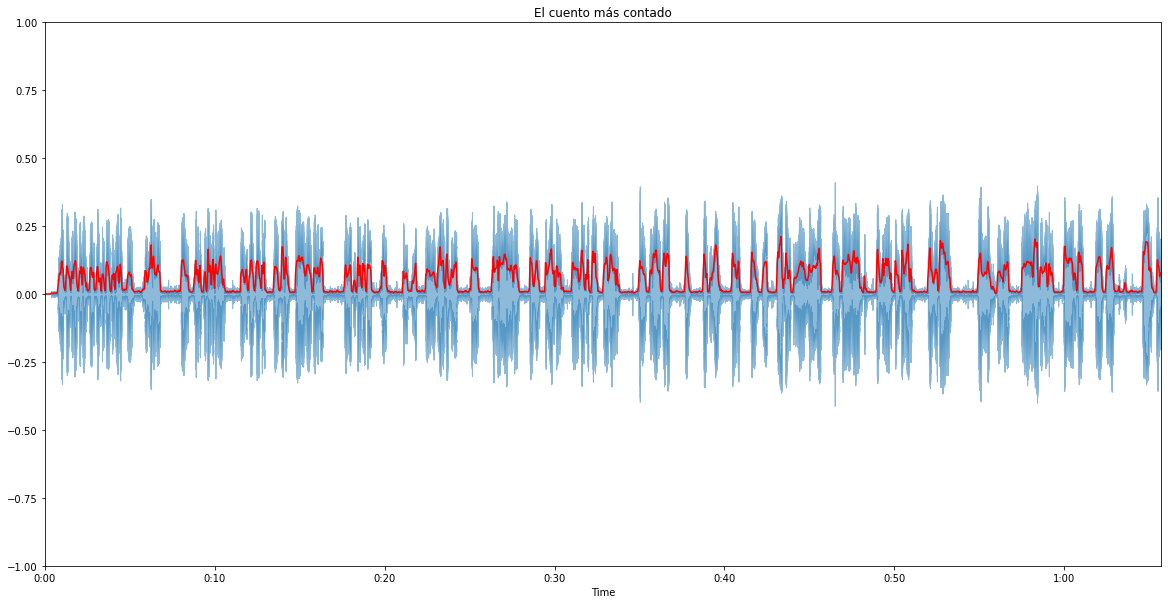

In [15]:
plt.figure(figsize=(20, 10))

librosa.display.waveplot(Signal, alpha=0.5)
plt.plot(t, rms, color="r")
plt.ylim((-1, 1))
plt.title("El cuento más contado")

**Mel Frequency Cepstral Coefficients (MFCCs)**
Sus coeficientes son basados en la percepción auditiva humana, por lo que puede ser muy util en audios de voz.

pendiente..., pienso que de los metodos anteriores puede que sea el mas relacionado

**band filters**
En las pruebas anteriores utilice el paquete librosa, pero recientemente encontre __[scipy signal](https://docs.scipy.org/doc/scipy/tutorial/signal.html)__ no se si esta relacionado con scikit o no pero cuenta con varios metodos especificos para señales como filtros y metodos y tal vez algo de machine learning

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import scipy.io as sio
import scipy.io.wavfile
import copy
from scipy.fftpack import ifft,fft

/Users/adrian/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/adrian/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


0


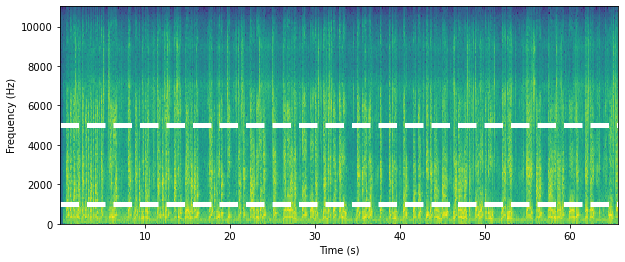

In [17]:
fs = sr
data = Signal
length = data.shape[0] / fs

frex,time,pwr = scipy.signal.spectrogram(data,fs)

plt.figure(figsize=(10, 4))
plt.pcolormesh(time,frex,np.log(pwr))
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')


# frequency ranges
frequency_range = [ [1000, 5000] ]

# draw boundary lines on the plot
colorz = 'wm';
for fi in range(0,len(frequency_range)):
    print(fi)
    plt.plot([time[0],time[-1]],[frequency_range[fi][0],frequency_range[fi][0]],colorz[fi]+'--',linewidth=5)
    plt.plot([time[0],time[-1]],[frequency_range[fi][1],frequency_range[fi][1]],colorz[fi]+'--',linewidth=5)

plt.show()

In [18]:
filtered_signal = np.zeros((1,len(Signal)))

for filter_iterator in range(len(frequency_range)):
    order    = round( 10*(fs/frequency_range[filter_iterator][0]) )
    order    += ~order%2
    filtkern = signal.firwin(order,frequency_range[filter_iterator],fs=fs,pass_zero=False)
    
    # zero-phase-shift filter
    fsig = signal.filtfilt(filtkern,1,Signal)
    filtered_signal = fsig
        

In [19]:
from IPython.display import Audio
# filtro aplicado
Audio(np.array(filtered_signal), rate=sr)

In [20]:
# audio original
Audio(Signal, rate=sr)

**Segmentacion de audios**

Consiste en seperar una señal de audio ininterruptidad en segmentos de contenido homogeneo, existen dos categorias:
1. Unsupervised
2. Semi-supervised

__segmentation con clasificacion__ : la clasificacion forma parte de la segmentación.
__segmentación fija (fixed window segmentation)__ :la señal es dividida en _overlapping mid-term_ segmentos y cada segmento es clasificado separado:
    - _naive merging_ :se unen segmentos _mid term_ que pertenecen a la misma clasificación para formar un segmento largo (ejemplo voz vs musica)
    - _Probability smooting_ : utiliza probabilidad para estimar las clases (el algoritmo viterbi puede ser diseñado para determinar la estimación de la probabilidad de los segmentos.)

__ join segmentation- classification based on cost funciton optimization__: la segmentación es tratada como una tarea de maximizacion donde la solucion obtiene el promedio.

__segmentacion sin clasificacion__: las segementaciones anteriores se base en una clasificación entrenada. pero existen problemas donde no es posible emplear una clasificación durante el proceso de segmentacion, esta classificacion es __unsupervised__.

_single change detection methods_: la salida consiste de _endpoints_ de los segemntos detectados, (no regresa etiquetas).

_segmentación con clustering_:  los segmentos detectados son _clustered_ agrupados y el resultado son _clusters_ que son usados para asignar etiquetas.

__detección de cambios en la señal(signal change detection)__
El objectivo es determinar los cambios significativos que ocurren en el contenido de una señal de audio.
basicos pasos:
1. Extrar la sequencia de _mod term feature_ de los vectors
2. Para cada par sucesiva de _feature vector_ calcular la funcion de distancia
3. Detectar el maximo local de la sequencia, Estos son los _endpoints_ detectados en los segmentos.

__segmentacion con clustering__: usado en segmentos de grupos donde son asignandos automaticamente a groups con la misma etiqueta. (ejemplos _speaker diarization_ quien dijo que?).

__semi-supervised clustering__: usa un par de reglas _constrains_. (Ejemplo: groups de segmentos de voz en un cluster de speakers y por la probabilidad determinar que los segmentos pertenezcan a la misma persona).

basico diagrama de flujo:

signal -> feature extraction -> feature normalization -> clustering k means -> probability estimation -> segment extraction -> segment limits (labels)

### prueba recognocimiento de palabras

In [21]:
import speech_recognition as sr
import json
from ibm_watson import SpeechToTextV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [22]:
def recognize_google(file_name):
    r = sr.Recognizer()
    with sr.AudioFile(file_name) as source:
        audio = r.listen(source)
        try:
            # t = r.recognize_sphinx(audio)
            # print(t)
            text = r.recognize_google(audio, language="es-MX")
            print(text)
            return text
        except sr.UnknownValueError:
            print("Audio Unintelligible")

        except sr.RequestError as e:
            print("cannot obtain results : {0}".format(e))
        except:
            print("error, something when wrong")
        return ''

In [23]:
def recognize_ibm(file_name):
    apiKey="ONJZfaapiQ15bZUQi5Xk-7NBb-aQXX0DzLhuW8P2R4ka"
    url="https://api.us-south.speech-to-text.watson.cloud.ibm.com/instances/633b4ffe-58d3-4b74-9c25-92d4e5204e16"
    authenticator = IAMAuthenticator(apiKey)
    stt = SpeechToTextV1(
        authenticator=authenticator
    )

    stt.set_service_url(url)
    
    with open(file_name,'rb') as f:
        res = stt.recognize(audio=f, content_type='audio/wav', model='es-MX_BroadbandModel',continuous=True)

        #print(json.dumps(res.get_result(), indent=2))
        #print(res.get_status_code())
        if(res.get_status_code() != 200):
            return ''

        text = res.get_result()['results'][0]['alternatives'][0]['transcript']
        print(text)
        return text

In [24]:
def audioRecognition(file_name,method = 'goggle'):
    if(method == 'google'):
        recognize_google(file_name)
    elif(method == 'ibm'):
        recognize_ibm(file_name)
        

In [25]:
# prueba de speech to text
print(audioRecognition(PATH +'/e.wav','google'))

cannot obtain results : recognition connection failed: [Errno 32] Broken pipe
None


In [26]:
print(audioRecognition(PATH +'/e.wav','ibm'))

cuanto más conectado encuentra más connotado es sin duda el de caperucita roja 
None
